In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd "/content/drive/Shareddrives/ES143/Final_Project"
!ls


/content/drive/Shareddrives/ES143/Final_Project
dataset  results  test	Yeabsira_Grayson_Grace_Jingfei-Final_Project.gdoc


In [ ]:
# Import any required libraries here
import cv2                   # OpenCV
import numpy as np           # numpy
import scipy.interpolate  # interpolation, used for questions 2, 3 and 4

# Use this line to make matplotlib plot inline (only need to call it once when importing matplotlib)
%matplotlib inline

import matplotlib.pyplot as plt
# Modify this line to adjust the displayed plot size. You can also call
# it with different parameters before specific plots.
plt.rcParams['figure.figsize'] = [10, 10]

In [ ]:
! pip install open3d

##Code to convert heic to jpg (only run if custom dataset has HEIC images)

In [ ]:
# !pip install pyheif
# import os
# import pyheif
# from PIL import Image
# import glob

# def convert_heic_to_jpg(source_folder, destination_folder=None):

#     if destination_folder is None:
#         destination_folder = source_folder

#     if not os.path.exists(destination_folder):
#         os.makedirs(destination_folder)

#     heic_files = glob.glob(os.path.join(source_folder, '*.HEIC')) + glob.glob(os.path.join(source_folder, '*.heic'))

#     for heic_path in heic_files:
#         heif_file = pyheif.read(heic_path)

#         image = Image.frombytes(
#             heif_file.mode,
#             heif_file.size,
#             heif_file.data,
#             "raw",
#             heif_file.mode,
#             heif_file.stride,
#         )

#         base_filename = os.path.splitext(os.path.basename(heic_path))[0]
#         jpg_filename = base_filename + '.jpg'
#         output_path = os.path.join(destination_folder, jpg_filename)

#         image.convert('RGB').save(output_path, "JPEG", quality=25)

#     print(f"Converted {len(heic_files)} HEIC images to JPEG and saved to '{destination_folder}'")

# source_folder = "/content/drive/Shareddrives/ES143/Final_Project/test"
# convert_heic_to_jpg(source_folder)



['/content/drive/Shareddrives/ES143/Final_Project/test/web/images/0000.jpg', '/content/drive/Shareddrives/ES143/Final_Project/test/web/images/0001.jpg']


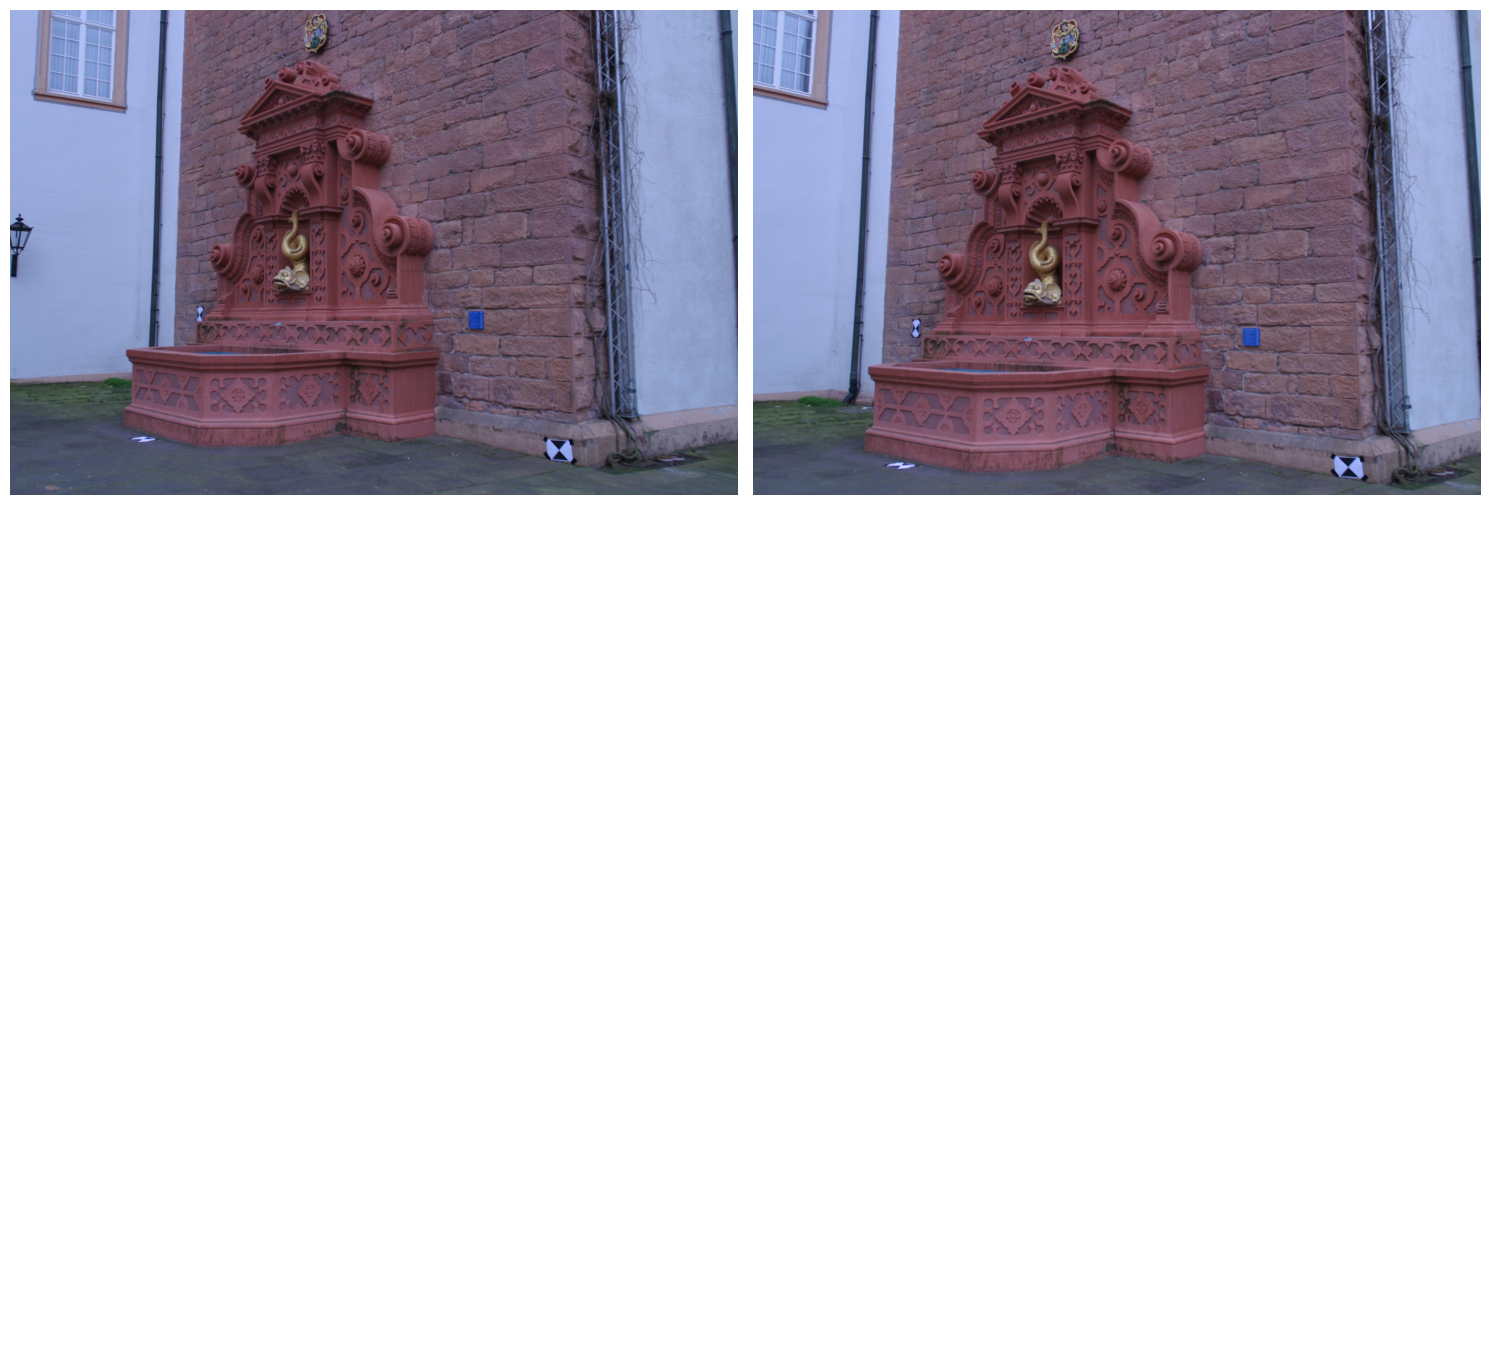

In [ ]:
import cv2
import matplotlib.pyplot as plt

def plot_images(image_paths):

    n = len(image_paths)

    grid_size = int(n**0.5) + 1 if n**0.5 % 1 != 0 else int(n**0.5)

    fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))

    axs = axs.flatten()

    for ax in axs[n:]:
        ax.axis('off')

    for img_path, ax in zip(image_paths, axs):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

import os
import glob

test_path = "/content/drive/Shareddrives/ES143/Final_Project/test/web/images"
image_format = 'jpg'

search_pattern = os.path.join(test_path, f'*.{image_format}')
image_files = glob.glob(search_pattern)
image_files.sort()

image_paths = [path for path in image_files][:2]
print(image_paths)
plot_images(image_paths)


##Helper functions

In [ ]:
def in2hom(X):
    """
    Convert from inhomogeneous to homogeneous coordinates

    Args:
      X  - NxD numpy array, tyically with D=2 (rows (x,y)) or D=3 (rows (x,y,z))

    Returns:
      Xh - Nx(D+1) numpy array with an appended column of ones
    """

    return np.concatenate([X, np.ones((X.shape[0], 1), dtype=np.float32)], axis=1)

# Convert from homogeneous to inhomogeneous coordinates
def hom2in(Xh):
    """
    Convert from homogeneous to inhomogeneous coordinates

    Args:
      Xh  - Nx(D+1) numpy array, tyically with D=2 (rows (x,y,w)) or D=3 (rows (x,y,z,w))

    Returns:
      X - NxD numpy array with the first D columns divided by column (D+1)
    """

    return Xh[:, :2] / Xh[:, 2:]

def normalizing_transform(X):
    """
    Compute a (Dx1)x(Dx1) normalizing transformation from N points in D dimensions

    Args:
      X - NxD numpy array, tyically with D=2 (rows (x,y)) or D=3 (rows (x,y,z))

    Returns:
      T - a (D+1)x(D+1) matrix that normalizes the points to be centered at their
          centroid, with average distance equal to sqrt(D)
    """

    # dimension of datapoints
    D = X.shape[1]

    # Compute centroid
    centroid = X.mean(axis=0, keepdims=True)

    # Compute the denominator of scale factor s
    denom = np.mean(np.sqrt(np.sum((X - centroid) ** 2, axis=1)))

    # Compute s, tx, ty
    s = np.sqrt(D) / denom
    t = -s * centroid[0, :]
    t = np.concatenate((t,np.array([1])))

    # return matrix T
    return np.concatenate((s*np.eye(D+1,D+1)[:,0:D], np.expand_dims(t,1)),axis=1)

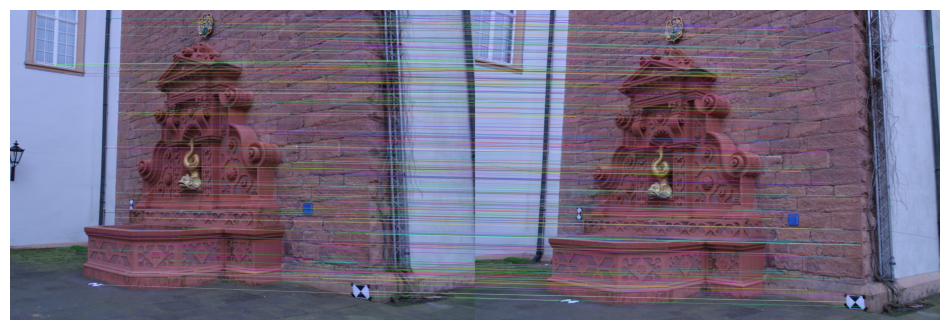

Homography Matrix:
 [[ 1.36513884e+00 -1.75553402e-02 -3.61250305e+02]
 [ 8.66941991e-02  1.09043051e+00 -8.63083204e+01]
 [ 5.40235947e-05 -8.32853075e-06  1.00000000e+00]]


In [ ]:
def detect_features(image_paths):
    """
    Detect and compute keypoints and descriptors for a list of image paths.
    """
    detector = cv2.SIFT_create()

    keypoints_all = []
    descriptors_all = []

    for path in image_paths:
        image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        keypoints, descriptors = detector.detectAndCompute(image, None)
        keypoints_all.append(keypoints)
        descriptors_all.append(descriptors)

    return keypoints_all, descriptors_all

def draw_keypoints(image_paths, keypoints_list):

    fig, axes = plt.subplots(nrows=len(image_paths), ncols=1, figsize=(10, 10 * len(image_paths)))
    if len(image_paths) == 1:
        axes = [axes]

    for ax, image_path, keypoints in zip(axes, image_paths, keypoints_list):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        im_keypoints = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        ax.imshow(im_keypoints)
        ax.axis('off')

    plt.show()



def match_features(descriptors1, descriptors2, crossCheck=True):
    """
    Match features between two sets of descriptors.
    """
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    matches = bf.match(descriptors1, descriptors2)
    return sorted(matches, key=lambda x: x.distance)

def find_good_matches(descriptors_list, good_match_percentage=0.15):
    """
    Find good matches between consecutive image pairs in a list of descriptors.
    """
    good_matches = []
    for i in range(len(descriptors_list) - 1):
        matches = match_features(descriptors_list[i], descriptors_list[i+1])
        good_matches.append(matches[:int(len(matches) * good_match_percentage)])
    return good_matches

def draw_matches(image_paths, keypoints_list, matches_list):
    """
    Draw matches and show the images.
    """
    for i in range(len(matches_list)):
        img1 = cv2.cvtColor(cv2.imread(image_paths[i]), cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(cv2.imread(image_paths[i+1]), cv2.COLOR_BGR2RGB)
        img_matches = cv2.drawMatches(img1, keypoints_list[i], img2, keypoints_list[i+1],
                                      matches_list[i], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.figure(figsize=(12, 6))
        plt.imshow(img_matches)
        plt.axis('off')
        plt.show()

def get_homography(keypoints1, keypoints2, matches):
    """
    Calculate the homography matrix from matches and keypoints.
    """
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    H, masked = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    return H


def main():

    keypoints_list, descriptors_list = detect_features(image_paths)
    matches_list = find_good_matches(descriptors_list)

    draw_matches(image_paths, keypoints_list, matches_list)

    if len(matches_list) > 0:
        H = get_homography(keypoints_list[0], keypoints_list[1], matches_list[0])
        print("Homography Matrix:\n", H)

if __name__ == "__main__":
    main()

In [ ]:
keypoints_list, descriptors_list = detect_features(image_paths)
matches_list = find_good_matches(descriptors_list)
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import open3d as o3d
import datetime
import plotly.graph_objects as go

class SceneReconstructor:
    def __init__(self, image_paths, K, results_path):
        self.image_paths = image_paths
        self.K = K
        self.results_path = results_path
        self.keypoints_list, self.descriptors_list = detect_features(image_paths)
        self.matches_list = find_good_matches(self.descriptors_list)
        self.points_3D = np.empty((0, 3), float)
        self.errors = []
        self.done = []
        self.point_map = {}
        self.point_counter = 0

    def compute_pose(self):
        view1, view2 = 0, 1
        keypoints1, keypoints2 = self.keypoints_list[view1], self.keypoints_list[view2]
        matches = self.matches_list[0]

        points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

        F, mask = cv2.findFundamentalMat(points1, points2, cv2.FM_RANSAC)

        points1 = points1[mask.ravel() == 1]
        points2 = points2[mask.ravel() == 1]

        E = self.K.T @ F @ self.K

        _, R, t, _ = cv2.recoverPose(E, points1, points2, self.K)

        # Triangulate Points
        P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
        P2 = np.hstack((R, t))
        points_3D_hom = cv2.triangulatePoints(self.K @ P1, self.K @ P2, points1, points2)
        points_3D = points_3D_hom[:3] / points_3D_hom[3]

        self.points_3D = np.vstack([self.points_3D, points_3D.T])
        self.done.append((keypoints1, R, t))

        # Calculate reprojection errors
        projected_points2 = cv2.projectPoints(points_3D.T.reshape(-1, 1, 3), R, t, self.K, None)[0]
        error = np.mean(np.linalg.norm(projected_points2.squeeze() - points2.squeeze(), axis=1))
        self.errors.append(error)

    def plot_points(self):
        timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        filename = f"reconstructed_{timestamp}.ply"
        file_path = os.path.join(self.results_path, filename)

        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(self.points_3D)
        o3d.io.write_point_cloud(file_path, pcd)

    def plot_points_plotly(self):
        xs = self.points_3D[:, 0]
        ys = self.points_3D[:, 1]
        zs = self.points_3D[:, 2]

        trace = go.Scatter3d(
            x=xs, y=ys, z=zs,
            mode='markers',
            marker=dict(
                size=2,
                opacity=0.8,
            )
        )

        layout = go.Layout(
            margin=dict(l=0, r=0, b=0, t=0),
            scene=dict(
                xaxis=dict(title='X'),
                yaxis=dict(title='Y'),
                zaxis=dict(title='Z')
            )
        )

        fig = go.Figure(data=[trace], layout=layout)
        fig.show()




K = np.array([[2759.48, 0, 1520.69 ], [0, 2764.16, 1006.81], [0, 0, 1]])
results_path = '/content/drive/Shareddrives/ES143/Final_Project/results'
reconstructor = SceneReconstructor(image_paths, K, results_path)
reconstructor.compute_pose()
reconstructor.plot_points()




In [ ]:
# Call the visualization method
reconstructor.plot_points_plotly()